In [24]:
"""
Created on Sun Mar 17 00:52:19 2019

@author: Neil Rodrigues
"""

import torch
import numpy as np
import torch.utils.data
#import torch.nn.functional as F
from torch.autograd import Variable
import timeit

class RNN:
    # Initialize the class
    def __init__(self, X, Y, hidden_dim):
        

        self.dtype = torch.FloatTensor

        X = torch.from_numpy(X).type(self.dtype)
        Y = torch.from_numpy(Y).type(self.dtype)
        self.X = Variable(X, requires_grad=False)
        self.Y = Variable(Y, requires_grad=False)
                 
        self.X_dim = X.shape[-1]
        self.Y_dim = Y.shape[-1]
        self.hidden_dim = hidden_dim
        self.lags = X.shape[0]
        
        # Initialize network weights and biases        
        self.Us, self.bs, self.Ws,self.Ui, self.bi, self.Wi,self.Uo, self.bo, self.Wo,self.Uf, self.bf, self.Wf, self.V, self.c = self.initialize_RNN()

        self.training_loss = []

        self.optimizer = torch.optim.Adam([self.Us, self.bs, self.Ws,self.Ui, self.bi, self.Wi,self.Uo, self.bo, self.Wo,self.Uf, self.bf, self.Wf, self.V, self.c], lr=1e-3)
    
    
    # Initialize network weights and biases using Xavier initialization
    def initialize_RNN(self):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))
            return Variable(xavier_stddev*torch.randn(in_dim, out_dim).type(self.dtype), requires_grad=True)
        
        Us = xavier_init(size=[self.X_dim, self.hidden_dim])
        bs = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
        Ws = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        Ui = xavier_init(size=[self.X_dim, self.hidden_dim])
        bi = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
        Wi = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        Uo = xavier_init(size=[self.X_dim, self.hidden_dim])
        bo = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
        Wo = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        Uf = xavier_init(size=[self.X_dim, self.hidden_dim])
        bf = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
        Wf = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)        
        V = xavier_init(size=[self.hidden_dim, self.Y_dim])
        c = Variable(torch.zeros(1,self.Y_dim).type(self.dtype), requires_grad=True)
        
        return Us, bs, Ws,Ui, bi, Wi,Uo, bo, Wo, Uf, bf, Wf, V, c
       
           
    # Evaluates the forward pass
    def forward_pass(self, X):
        H = torch.zeros(X.shape[1], self.hidden_dim).type(self.dtype)
        S = torch.zeros(X.shape[1], self.hidden_dim).type(self.dtype)
        for i in range(0, self.lags):
            se = torch.tanh(torch.matmul(H,self.Ws) + torch.matmul(X[i,:,:],self.Us) + self.bs);
            it = torch.sigmoid(torch.matmul(H,self.Wi) + torch.matmul(X[i,:,:],self.Ui) + self.bi);
            ft = torch.sigmoid(torch.matmul(H,self.Wf) + torch.matmul(X[i,:,:],self.Uf) + self.bf);
            ot = torch.sigmoid(torch.matmul(H,self.Wo) + torch.matmul(X[i,:,:],self.Uo) + self.bo);
            S = ft*S + it*se ; 
            H = ot*torch.tanh(S) ;
        H = torch.matmul(H,self.V) + self.c
        return H
    
    
    # Computes the mean square error loss
    def compute_loss(self, X, Y):
        loss = torch.mean((Y - self.forward_pass(X))**2)
        return loss
        
    # Fetches a mini-batch of data
    def fetch_minibatch(self,X, y, N_batch):
        N = X.shape[1]
        idx = torch.randperm(N)[0:N_batch]
        X_batch = X[:,idx,:]
        y_batch = y[idx,:]        
        return X_batch, y_batch
    
    
    # Trains the model by minimizing the MSE loss
    def train(self, nIter = 20000, batch_size = 128):
        
        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch mini-batch
            X_batch, Y_batch = self.fetch_minibatch(self.X, self.Y, batch_size)
            
            loss = self.compute_loss(X_batch, Y_batch)

            self.training_loss.append(loss)

            loss.backward()

            self.optimizer.step()

            self.optimizer.zero_grad()
            
            # Print
            if it % 1000 == 0:
                elapsed = timeit.default_timer() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss.cpu().data.numpy(), elapsed))
                start_time = timeit.default_timer()
    
    
   # Evaluates predictions at test points    
    def predict(self, X_star):
        X_star = torch.from_numpy(X_star).type(self.dtype)
        y_star = self.forward_pass(X_star)
        y_star = y_star.cpu().data.numpy()
        return y_star
    



In [25]:

import numpy as np
import matplotlib.pyplot as plt

#from models_tf import RNN
from model_train import RNN

np.random.seed(1234)
    
if __name__ == "__main__":
    
    def create_dataset(data, lags):
        N = len(data)-lags
        data_dim = data.shape[1]
        X = np.zeros((lags, N, data_dim))
        Y = np.zeros((N, data_dim))
        for i in range(0,N):
            X[:,i,:] = data[i:(i+lags), :]
            Y[i,:] = data[i + lags, :]
        return X, Y

    from scipy.integrate import odeint
    import numpy as np
    
    def prey(y,t,a,b,c,d):
        x,z=y;
        dydt = [x*(a-b*z),-z*(c-d*x)];
        return dydt
    
    def normalize(A):
        mean_1 = np.mean(A[:,0]);
        std_1 = np.std(A[:,0]);
        mean_2 = np.mean(A[:,1]);
        std_2 = np.std(A[:,1]);        
        A[:,0]=(A[:,0]-np.mean(A[:,0]))/np.std(A[:,0])
        A[:,1]=(A[:,1]-np.mean(A[:,1]))/np.std(A[:,1])
        #x = (x-min_val) / (max_val-min_val)
        return A,mean_1,std_1,mean_2,std_2

    def denormalise(A):
        A[:,0]=A[:,0]*std_1 + mean_1;
        A[:,1]=A[:,1]*std_2 + mean_2;
        return A
    
    y0=[10,5];
    t=np.arange(0,60,0.03);
    dataset=odeint(prey,y0,t,args=(1,0.1,1.5,0.75))
    dataset,mean_1,std_1,mean_2,std_2 = normalize(dataset)
    dataset=np.array(dataset);

    train_size = int(len(dataset) * (2.0/3.0))
    train = dataset[0:train_size,:]
     
    lags = 8
    X, Y = create_dataset(train, lags)
    
    # Model creation
    hidden_dim = 20
    model = RNN(X, Y, hidden_dim)
    
    model.train(nIter = 20000, batch_size = 128)
    
    # Prediction
    pred = np.zeros((len(dataset)-lags, Y.shape[-1]))
    X_tmp =  np.copy(X[:,0:1,:])
    for i in range(0, len(dataset)-lags):
        pred[i] = model.predict(X_tmp)
        X_tmp[:-1,:,:] = X_tmp[1:,:,:] 
        X_tmp[-1,:,:] = pred[i]
    pred_y = pred[X.shape[1]:];   
    ydes = dataset[lags:];
    ydes = dataset[X.shape[1]:];
    L2_X = np.sqrt(np.sum((pred_y[0,:] - ydes[0,:])**2)) / np.sqrt(np.sum(ydes[0,:]**2));
    L2_Y = np.sqrt(np.sum((pred_y[1,:] - ydes[1,:])**2)) / np.sqrt(np.sum(ydes[1,:]**2));
    print(L2_X);
    print(L2_Y);
    dataset=denormalise(dataset);
    pred = denormalise(pred);        



It: 0, Loss: 1.195e+00, Time: 0.04
It: 1000, Loss: 3.484e-04, Time: 7.88
It: 2000, Loss: 5.654e-05, Time: 8.00
It: 3000, Loss: 2.632e-05, Time: 8.18
It: 4000, Loss: 1.316e-05, Time: 8.26
It: 5000, Loss: 8.934e-06, Time: 8.32
It: 6000, Loss: 7.508e-06, Time: 8.44
It: 7000, Loss: 3.726e-06, Time: 8.67
It: 8000, Loss: 2.327e-06, Time: 8.95
It: 9000, Loss: 1.894e-06, Time: 9.09
It: 10000, Loss: 1.373e-06, Time: 9.14
It: 11000, Loss: 1.715e-06, Time: 9.40
It: 12000, Loss: 9.868e-07, Time: 9.54
It: 13000, Loss: 7.067e-07, Time: 9.68
It: 14000, Loss: 1.145e-06, Time: 9.88
It: 15000, Loss: 8.738e-07, Time: 10.18
It: 16000, Loss: 5.982e-07, Time: 10.42
It: 17000, Loss: 2.079e-06, Time: 10.57
It: 18000, Loss: 6.881e-07, Time: 10.96
It: 19000, Loss: 7.694e-07, Time: 11.28
0.24250742212088724
0.23723861232542376


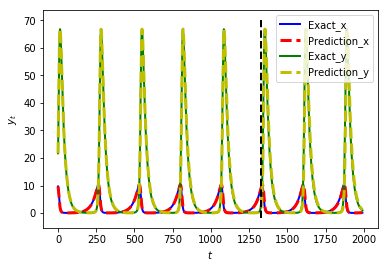

In [31]:
plt.figure(1)
plt.plot(dataset[lags:,0], 'b-', linewidth = 2, label = "Exact_x")
plt.plot(pred[:,0], 'r--', linewidth = 3, label = "Prediction_x")
plt.plot(dataset[lags:,1], 'g-', linewidth = 2, label = "Exact_y")
plt.plot(pred[:,1], 'y--', linewidth = 3, label = "Prediction_y")
plt.plot(X.shape[1]*np.ones((2,1)), np.linspace(-1.75,70,2), 'k--', linewidth=2)
plt.axis('tight')
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend(loc='upper right')
